# 4. Gaussian Mixture Models 
Gaussian Mixture Models are a form of **density estimation**. They give us an approximation of the probability distribution of our data. We want to use gaussian mixture models when we notice that our data is multimodal (meaning there are multiple modes or bumps). From probability, we can recall that the **mode** is just the most common value. For instance, a multi modal distribution can be seen below:

In [35]:
import numpy as np
from scipy.stats import bernoulli, binom, norm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

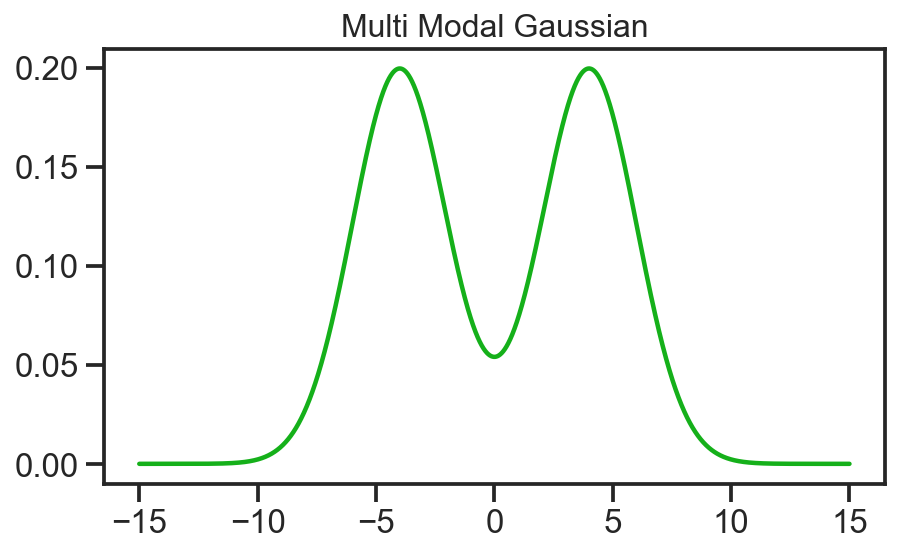

In [51]:
x_axis = np.arange(-15, 15, 0.001)

fig = plt.figure(figsize=(7,4))
plt.plot(x_axis, norm.pdf(x_axis, -4, 2) + norm.pdf(x_axis, 4, 2), c=sns.xkcd_rgb["green"])

plt.title("Multi Modal Gaussian", fontsize=16)
plt.show()

Multi modal gaussians can be viewed as a **linear combination** of individual gaussians:

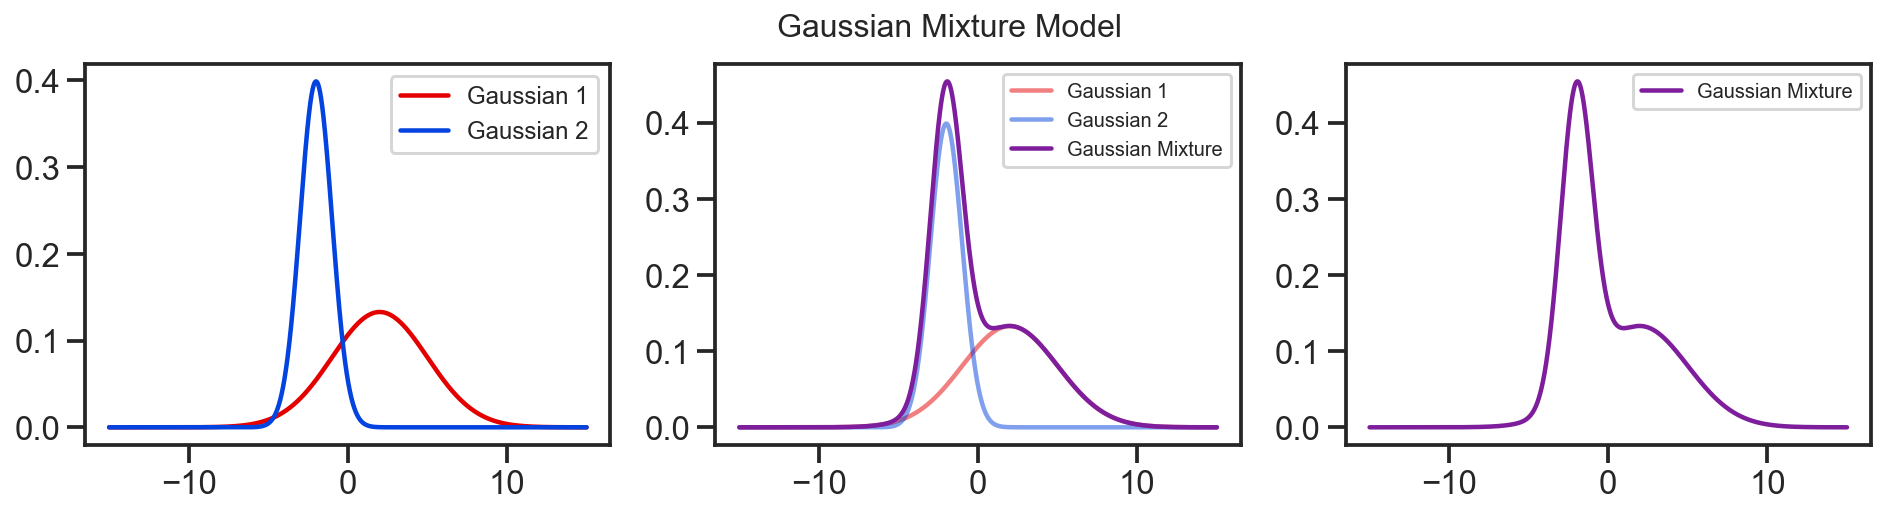

In [34]:
x_axis = np.arange(-15, 15, 0.001)
mu = {
    "1": 2,
    "2": -2
}
sigma = {
    "1": 3,
    "2": 1
}

gaussian_1 = norm.pdf(x_axis, mu["1"], sigma["1"])
gaussian_2 = norm.pdf(x_axis, mu["2"], sigma["2"])

fig = plt.figure(figsize=(16,3.5))

plt.subplot(1, 3, 1)
plt.plot(x_axis, gaussian_1, c=sns.xkcd_rgb["red"])
plt.plot(x_axis, gaussian_2, c=sns.xkcd_rgb["blue"])
plt.legend(["Gaussian 1", "Gaussian 2"], fontsize=12)

plt.subplot(1, 3, 2)
plt.plot(x_axis, gaussian_1, c=sns.xkcd_rgb["red"], alpha=0.5)
plt.plot(x_axis, gaussian_2, c=sns.xkcd_rgb["blue"], alpha=0.5)
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["Gaussian 1", "Gaussian 2", "Gaussian Mixture"], fontsize=10)

plt.subplot(1, 3, 3)
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["Gaussian Mixture"], fontsize=10)

fig.suptitle('Gaussian Mixture Model', fontsize=16)

plt.show()

A very important thing to note is that GMM's are a type of model known as a **generative model**. What that means is that if you were to be presented with a set of observations, $x$, that was generated from the gaussian mixture distribution, it would be generated as follows:

```
for i in range(len(X)):
    select gaussian based on prior distribution of gaussians
    sample from selected gaussian to generate data point x
```

This can be seen in code below:

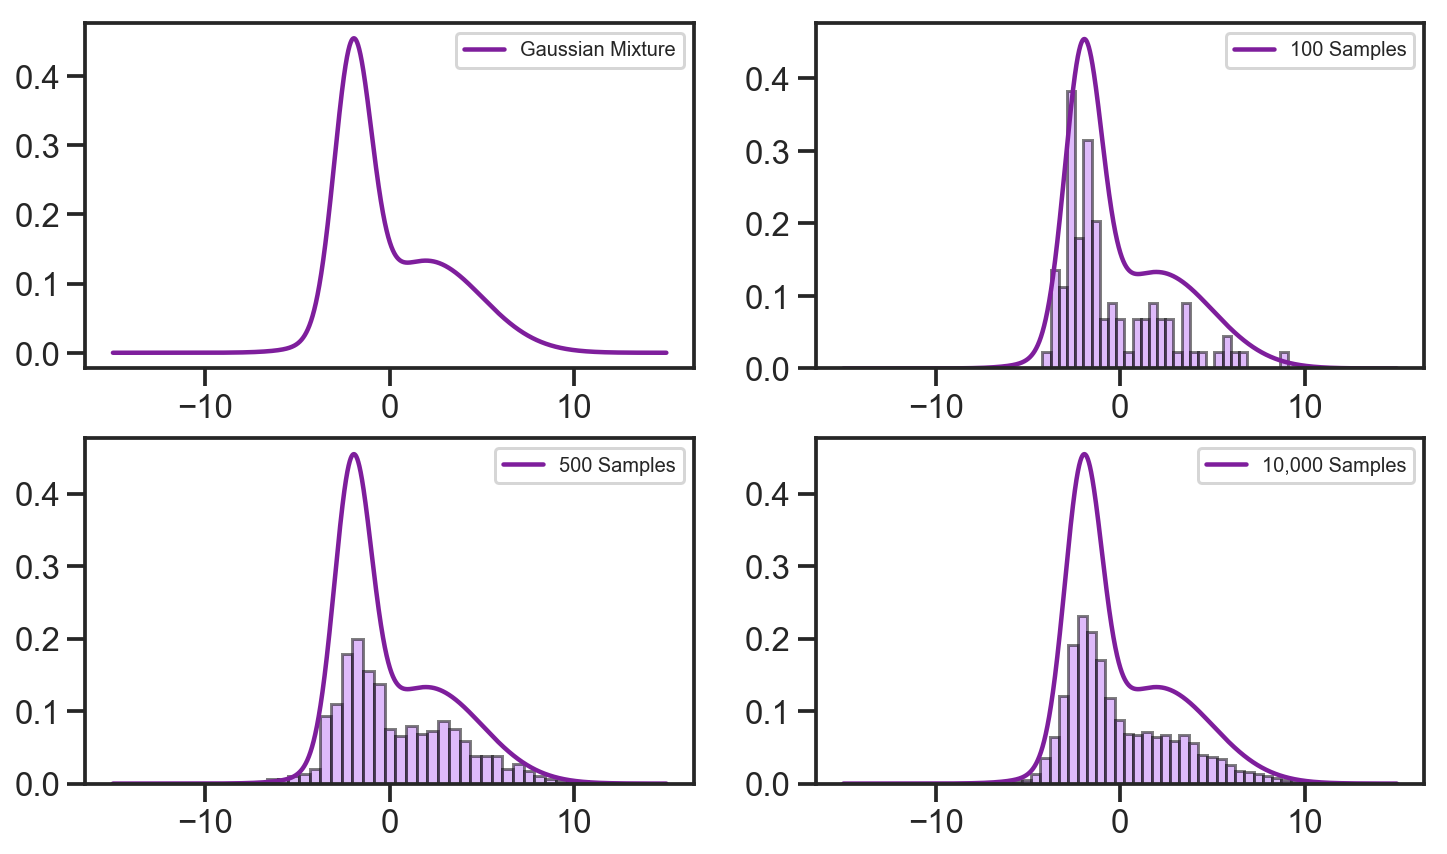

In [116]:
fig = plt.figure(figsize=(12,7))

# Upper left
plt.subplot(2, 2, 1)
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["Gaussian Mixture"], fontsize=10)

def generate_x(num_samples=100):
    num_gaussians = 2
    prior = np.array([0.5, 0.5]) # Uniform prior across distribution 1 and 2
    X = [] 
    for i in range(num_samples):
        selected_gaussian = np.random.choice(num_gaussians, p=prior)
        x = norm.rvs(mu[str(selected_gaussian + 1)], sigma[str(selected_gaussian + 1)])
        X.append(x)
    return X

# Upper right
plt.subplot(2, 2, 2)
plt.hist(generate_x(), bins=30, density=True, color=sns.xkcd_rgb["light purple"], alpha=0.5, edgecolor="black")
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["100 Samples"], fontsize=10)

# lower left
plt.subplot(2, 2, 3)
plt.hist(generate_x(500), bins=30, density=True, color=sns.xkcd_rgb["light purple"], alpha=0.5, edgecolor="black")
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["500 Samples"], fontsize=10)

# lower right
plt.subplot(2, 2, 4)
plt.hist(generate_x(10000), bins=50, density=True, color=sns.xkcd_rgb["light purple"], alpha=0.5, edgecolor="black")
plt.plot(x_axis, gaussian_1 + gaussian_2, c=sns.xkcd_rgb["purple"])
plt.legend(["10,000 Samples"], fontsize=10)


plt.show()

We have our data generation process encapsulated in the function `generate_x`, and we can see that was we draw more samples we approximate the shape closer and closer. Let's now take a moment to hone in on the mathematics at work here.

As I stated earlier, a Gaussian mixture is just the sum of weighted gaussians. To represent these weights we will introduce a new symbol called $\pi$. $\pi_k$ is the probability that x belongs to the $k$th Gaussian. 

$$p(x) = \pi_1 N(\mu_1, \Sigma_1) + \pi_2 N(\mu_2, \Sigma_2) + \pi_3 N(\mu_3, \Sigma_3)$$

$\pi$ can be thought of as a **prior**, specifically the prior probability of a data point being generated from a particular gaussian. LEAVING OFF HERE.

### 1.1 $\pi$ is a distribution
Notice that there is a constraint here that all of the $\pi$'s have to sum to 1. 

$$1 = \int p(x)dx = \int \pi_1 N(x | \mu_1, \Sigma_1)dx + \pi_2 N(x | \mu_2, \Sigma_2)dx$$
$$\pi_1 1 + \pi_2 1$$

### 1.2 Latent Variables
Another way of thinking of this is that we introduced a new random variable called "Z". $Z$ represents which gaussian the data came from. So, we can say that:

$$\pi_k = P(Z = k)$$

This is like saying that there is some hidden cause called $Z$ that we can't measure. Each of these $Z$'s is causing a gaussian to be generated, and all we can see in our data is the combined effects of those individual $Z$'s. This will be important because it puts GMM's into the framework of **expectation maximization**.

### 1.3 Training a GMM
Training a GMM is very much like the k-means algorithm. There are two steps that mirror what we saw with k-means. 

1. **Calculate Responsibilites**<br>
$\gamma_k^{(n)}$ is the responsibility of the $k$th gaussian for generating the $n$th point. This is just the proportion of that gaussian, divided by all of the gaussians. If $\pi_k$ is large here, then it will overtake the other gaussians, and this will be approximately equal to 1. 
$$\gamma_k^{(n)} = p(z^{(n)}|x) = \frac{\pi_k N (x^{(n)} | \mu_k, \Sigma_k) }{\sum_{j=1}^K \pi_j N (x^{(n)} | \mu_j, \Sigma_j)}$$

2. **Calculate model parameters of the gaussians**
We now need to recalculate the means, covariances, and $\pi$s. The way that this is done is also similar to k-means, where we weight each samples influence on the parameter, by the responsibility. If that responsibility is small, then that $x$ matters less in the total calculation. 
$$\mu_k = \frac{1}{N_k}\sum_{n=1}^N \gamma_k^{(n)} x^{(n)}$$
$$\Sigma_k = \frac{1}{N_k} \sum_{n=1}^N \gamma_k^{(n)} (x^{(n)} - \mu_k)(x^{(n)} - \mu_k)^T$$ 
$$\pi_k = \frac{N_k}{N} \; with \; N_k = \sum_{n=1}^N \gamma_k^{(n)}$$

---

<br>
# 2. GMM vs Soft K-Means
Lets look at both **soft k-means** and **gmm's** side by side. Recall that for k-means the algorithm looked like: 

**Pseudocode**<br>
```
Initialize m1...mk = random points in X
While not converged:
    Step 1: Calculate cluster responsibilities
```

$$r_k^{(n)} = \frac{exp\Big[-\beta d(m_k, x^{(n)})\Big]}{\sum_j exp \Big[-\beta d(m_j, x^{(n)})\Big]}$$

```
    Step 2: Recalculate means
```
$$m_k = \frac{\sum_n r_k^{(n)}x^{(n)}}{\sum_n r_k^{(n)}}$$


## 2.1 Compare Steps
Let's now compare the two steps of each training algorithm. 

> 1. We can see that the first step in both is to calculate the responsibilities.
2. The second step in both is to calculate the model parameters. 

We can see now why **k-means** looks for clusters of equal weight. It is because it has no $\pi$ variable. This is equivalent to saying that $\pi$ is uniform or equal to $\frac{1}{k}$. Note, this means that GMMs are limited in the same way as K means, since you still have to choose $k$. 

The second thing to notice is that k-means has this $\beta$ term, whereas GMMs have the full covariance $\Sigma$. This allows GMMs to have a lot more flexibility in the shape of its distribution. With K-means, since you only have this one $\beta$ it means that all of your clusters have to be spherical. With a full covariance matrix you can have any type of elliptical shape in any orientation. Notice, finally, that the equations for the mean are exactly the same.

In conclusion, we can think of soft k-means as a GMM where each cluster has the same weight, and each cluster is spherical with the same radius. 

--- 

# 3. Gaussian Mixture Model in Code 
Notes: 
* Each sample ($N$ total) has a responsibility associated with it, which is just really the probability the it belongs to each specific cluster, of which there are $k$ total.
* The idea of responsibility, $\gamma$, and overall gaussian weight, $\pi$, may be slightly confusing. The best way to think of it is that the responsibility is saying: 
> * "*the probability that a specific sample belongs to a specific cluster*" 
* While the overall gaussian weight is saying:
> * "*based on all of the responsibilities across all of the samples, which clusters are responsible for containing most of the points?*"

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

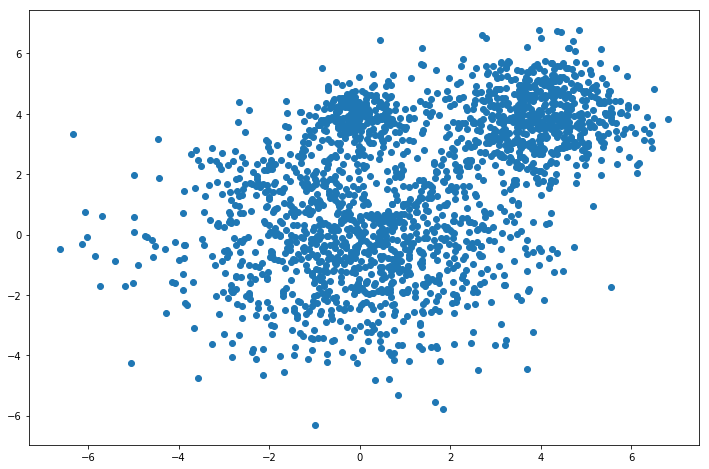

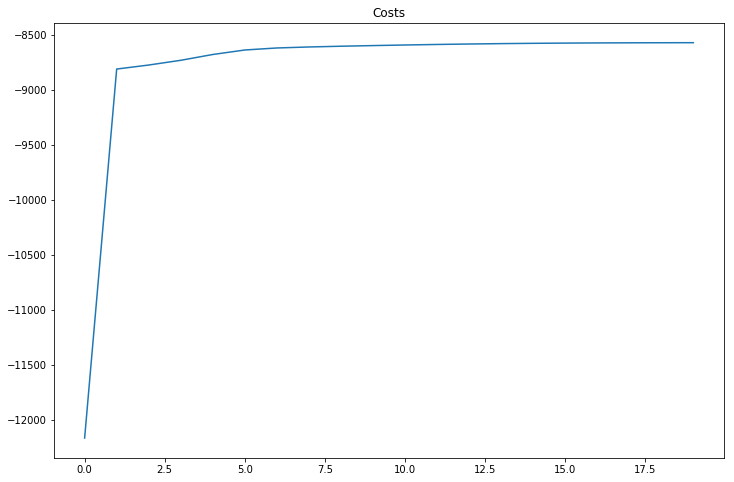

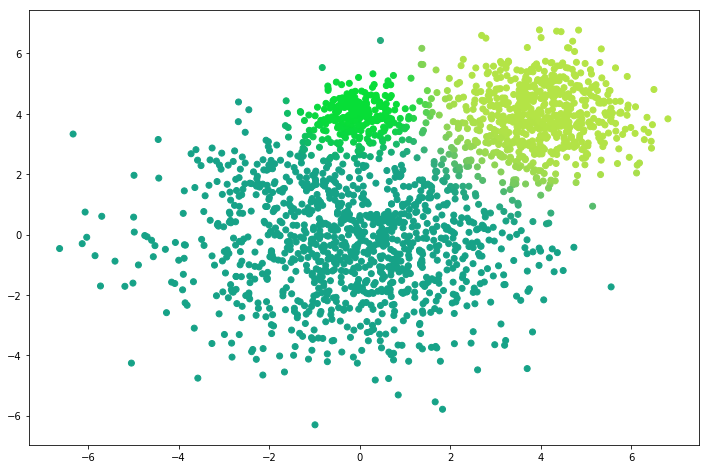

pi: [0.57123739 0.11635457 0.31240805]
means: [[-0.10583348 -0.09845038]
 [-0.02874022  3.95548158]
 [ 3.92961981  3.91007064]]
covariances: [[[ 3.80843337 -0.04674864]
  [-0.04674864  3.62278124]]

 [[ 0.32512724  0.04160356]
  [ 0.04160356  0.29986049]]

 [[ 1.06874608  0.02467758]
  [ 0.02467758  1.08783845]]]


In [13]:
def gmm(X, K, max_iter=20, smoothing=1e-2):
  N, D = X.shape # Get number of rows and columns in X
  M = np.zeros((K, D)) # Set the means to zeros
  R = np.zeros((N, K)) # Set the responsibilities to zeros. 
  C = np.zeros((K, D, D)) # Covariance matrix, 3 dimensional
  pi = np.ones(K) / K # 1-d, uniform distribution
  
  for k in range(K):
    M[k] = X[np.random.choice(N)] # set the means to random points in X
    C[k] = np.diag(np.ones(D))
  
  costs = np.zeros(max_iter)
  weighted_pdfs = np.zeros((N, K)) # store pdf values
  
  """Start iterating through algorithm up until max iter"""
  for i in range(max_iter):
    """---- Step 1: Calculate responsibilities ----"""
    for k in range(K):
      for n in range(N):
        weighted_pdfs[n, k] = pi[k]*multivariate_normal.pdf(X[n], M[k], C[k])
        
    for k in range(K):
      for n in range(N):
        R[n, k] = weighted_pdfs[n, k] / weighted_pdfs[n, :].sum()
  
    """---- Step 2: Re-Calculate parameters (pi, mu, cov) ----"""
    for k in range(K):
      Nk = R[:, k].sum() # sum of all respons for specific gaussian k
      pi[k] = Nk / N
      M[k] = R[:, k].dot(X) / Nk
      # Regularization occuring for covariance 
      C[k] = np.sum(R[n,k]*np.outer(X[n] - M[k], X[n] - M[k]) for n in range(N)) / Nk + np.eye(D)*smoothing

      # Calculate log likelihood!!!
      costs[i] = np.log(weighted_pdfs.sum(axis=1)).sum()
      if i > 0:
        if np.abs(costs[i] - costs[i - 1]) < 0.1:
          break
     
  fig, ax = plt.subplots(figsize=(12,8))
  plt.plot(costs)
  plt.title("Costs")
  plt.show()
  
  random_colors = np.random.random((K, 3))
  colors = R.dot(random_colors)
  fig, ax = plt.subplots(figsize=(12,8))
  plt.scatter(X[:,0], X[:,1], c=colors)
  plt.show()

  print("pi:", pi)
  print("means:", M)
  print("covariances:", C)
  return R
  
def main():
  """Creating 3 Gaussian distributed clusters"""
  D = 2 
  s = 4
  mu1 = np.array([0, 0])
  mu2 = np.array([s, s])
  mu3 = np.array([0, s])
  
  N = 2000 # number of samples
  X = np.zeros((N, D))
  X[:1200, :] = np.random.randn(1200, D)*2 + mu1 # Covariance = 2
  X[1200:1800, :] = np.random.randn(600, D) + mu2 # Cov = 1
  X[1800:, :] = np.random.randn(200, D)*0.5 + mu3 # Cov = 0.5
  
  fig, ax = plt.subplots(figsize=(12,8))
  plt.scatter(X[:, 0], X[:, 1])
  plt.show()
  
  K = 3 
  gmm(X, K)
  
if __name__ == '__main__':
  main()

---

<br>
# 4. Singular Covariance Problem 
To get a better idea for why this may be a problem, lets think about a one dimensional gaussian for a second. Imagine that all of the points are close together, so that they variance is almost 0. Or, consider what happens if you are trying to find the variance of just 1 point. In the gaussian formula, we divide by the variance. This means that if the variance is 0, then we are dividing by 0, which results in a singularity. 


You can think of inverting the matrix as taking 1 over it, since something times 1 over itself will be 1, or our identity. 
$$A * \frac{1}{A} = Identity$$

So in multiple dimensions, it is the same problem. If your covariance is too small, the covariance will approach infinity. This is yet another disadvantage of falling into local minimum. How can we fix this problem?

## 4.1 Diagonal Covariance
One solution to fix this problem is to use what is called a diagonal covariance. Diagonal covariance matrices are very useful, not only for avoiding the singularity problem, but also for speeding up our computation. When you have a diagonal covariance, it is very easy to take the inverse. You just take every element that is not 0, which will be along the diagonal, and you then invert it; i.e. you take 1 over that element.

<img src="https://drive.google.com/uc?id=1g2JKWHMsdOk-q6O5IUM0PyBbFnNxWpxk">

The assumption that you are making when using a diagonal covariance is that each of your dimensions is independent. 

$$\Sigma_{ij} = E\Big[(x_i - \mu_i)(x_j - \mu_j)\Big]$$
And we can then write (because $x_i$ and $x_j$ are independent we can split the expectations):
$$\Sigma_{ij} = E\Big[(x_i - \mu_i)\Big]E\Big[(x_j - \mu_j)\Big]$$
$$\Sigma_{ij} = \Big(E(x_i) - \mu_i\Big)\Big(E(x_j) - \mu_j\Big)$$
$$\Sigma_{ij} = (\mu_i - \mu_i)(\mu_j - \mu_j)$$
$$\Sigma_{ij} = 0$$

From the above you can see how we eventually end up at 0. You can think of the diagonal matrix as a means of regularization-you are making your model simpler by using less parameters. 

## 4.2 Spherical Gaussian 
Sometimes even when you use diagonal covariance, you still get singularities. In that case you may want to use a spherical gaussian, where we use the same covariance along every dimension. This is even less computationaly expensive. 

---

<br>
# 5. Kernel Density Estimation
Kernel Density Estimation is just the fitting of a probability distribution with kernels. Before we really dive into this, let's first just talk about what the easiest solution to this problem is. the simplest solution is to just take the frequency estimate-a **histogram**! This would work perfectly for discrete probabilities and would be the maximum likelihood estimate. 

However, if our data was continuous (as the data we have been working with so far has been), then the easiest way it to use a **gaussian mixture model**! In fact, using a gaussian mixture model we are inherently doing kernel density estimation, where the gaussian is the kernel. However, we will have the problem that we can only have gaussian looking shapes in your distribution. This is the same problem we have with k-means, in we have to determine the correct number of components to use. One strategy would be to look at the distribution of the data, and to look at the number of peaks seen in the histogram. 

Another method is to use gaussians with all the same variance, set the number of gaussians equal to the number of points, and use the GMM algorithm on that. 

$$P(x) = \frac{1}{N}\sum_{i=1}^N \frac{1}{(2\pi h^2)^\frac{D}{2}} exp\Big(-\frac{||x - x_n||^2}{2h^2}\Big)$$

Here we call **h** the window size, and you would need to play with h in order to find the ideal size for your distribution. 

---

<br>
# 6.  Expectation Maximization
We are now going to take an abstract look at the Gaussian Mixture Model, and create a framework called **Expectation Maximization**, aka the **E-M Algorithm**. This algorithm generalizes some important concepts that we have talked about, such as latent variables, coordinate descent, and increasing our likelihood guarantee. 

### 6.1 Maximum Likelihood
The first important thing that we should realize is that we still start off trying to do maximum likehood. We have some data $X$ and some model $\theta$, and we are trying to maximize the probability of observing our data, $X$, given $\theta$, which generally defines are gaussian distribution.

$$Maximize \rightarrow \; P(X | \theta) \; or \; log P(X | \theta) = L(\theta)$$

By introducing hidden variables called $Z$, we can imagine that $P(X | \theta)$ is actually a marginalized distribution over $P(X, Z | \theta)$:

$$P(X | \theta) = \sum_Z P(X, Z | \theta)$$

We can expand that to get: 

$$P(X | \theta) = \sum_Z P(X, Z | \theta) = \sum_Z P(X | Z, \theta)P(Z|\theta)$$

### 6.2 EM Algorithm: 2 steps
As we know, in the EM algorithm there are two main steps; one where we adjust $Z$ and one where we adjust $\theta$. 

#### E-step: 
> We can think of the E-step as finding the distribution of Z given X and the current setting of theta:

$$P(Z | X, \theta_n)$$ 

#### M-step: 
> Then you can think of the M-step as finding the best $\theta$ that maximizes the joint distribution of $log P(X, Z | \theta)$. However, instead of maximizing this directly, we are maximizing the expected value of this over the distribution we found in the previous step, which was the distribution $P(Z | X, \theta_n)$ :

$$Maximize \rightarrow E \Big[log P(X, Z | \theta)\Big]$$